### building blocks for quick activity detector on neuropixels. 
The code here should:
    - read a sglx file (spikes, ain and d_in) into an array
    - find the triggers
    - filter and CAR the spikes channel
    - get peri_triger thresholded supra-threshold events
    - make psths/rasters
    - determine which N channels have events, and which are 'silent'
    - bring in the probe file
    - make a probe file including these channels.

In [1]:
import numpy as np
import logging
import socket
import glob
import os
import matplotlib.pyplot as plt

from importlib import reload

#from intan2kwik import kwd

#mountainsort imports (for sorting)
#import mountainlab_pytools.mlproc as mlp
from pipefinch.pipeline import sglxutil as sglu



# Setup the logger
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)
        
logger.info('Logger set')
logger.info('Hostname {}'.format(socket.gethostname()))

2019-06-04 23:50:10,812 - root - INFO - Logger set
2019-06-04 23:50:10,814 - root - INFO - Hostname lookfar


#### read single sglx file

In [2]:
from pipefinch.pipeline import filestructure as et
reload(et)
#reload(kwd)

# sess_par = {'bird': 'p14r14',
#            'sess': '2019-02-14_2250_01'}
sess_par = {'bird': 'p14r14',
           'sess': '2019-02-15_3125_01',
           'probe': 'probe_0', # probe to sort ('probe_0', 'probe_1') (to lookup in the rig_par which port to extract)
           'sort': 1}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sess_par['sort'])
# convenient paths
raw_folder = exp_struct['folders']['raw']

##### make the sgl file structure and retrieve bin and meta files

In [3]:
# in zpike
sess_folder = '/mnt/microdrive/birds/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0'
#in lookfar
sess_folder = '/Users/zeke/experiment/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0'
all_probe_folders = glob.glob(os.path.join(sess_folder, '*'))
all_probe_folders

['/Users/zeke/experiment/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0/2019-05-27_stimsim_0000_00_g0_imec0',
 '/Users/zeke/experiment/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0/2019-05-27_stimsim_0000_00_g0_t0.nidq.bin',
 '/Users/zeke/experiment/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0/2019-05-27_stimsim_0000_00_g0_t0.nidq.meta']

In [4]:
# continue with pipefinch.pipeline.sglxutil

##### read the meta and determine samplerate, number of channels, and channels

In [5]:
# do it, continue with pipefinch.pipeline.sglxutil

##### memmap the file

#### The imec file.
Here's the meaning of some of the metadata https://github.com/JaneliaSciComp/JRCLUST/wiki/.meta-file.
In particular, there is an explanation of what channels in the probe are used and where they are located in the block.
More detailed meta here https://github.com/billkarsh/SpikeGLX/blob/master/Markdown/Metadata.md.

In [56]:
reload(sglu)
# you just need the meta to load everything
imec_meta_file_path = os.path.join('/Users/zeke/experiment/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0/2019-05-27_stimsim_0000_00_g0_imec0', '2019-05-27_stimsim_0000_00_g0_t0.imec0.ap.meta')
# these should come from the .meta file
imec_meta_dict = sglu.get_imec_meta(imec_meta_file_path)

imec0 = sglu.get_imec_data(imec_meta_file_path)
n_chan = imec_meta_dict['nsavedchans'] #nSavedChans in meta file
s_f = imec0['meta']['s_f'] #30000.533148 #imSampleRate in meta file

imec0['neural']
# this yields an array shaped [n_ch, n_sample]

memmap([[22, 21, 24, ..., 18, 18, 21],
        [ 9, 12, 13, ...,  3,  3,  3],
        [72, 72, 72, ..., 65, 65, 63],
        ...,
        [75, 70, 71, ..., 61, 57, 55],
        [95, 98, 97, ..., 96, 93, 91],
        [64, 64, 64, ...,  0,  0,  0]], dtype=int16)

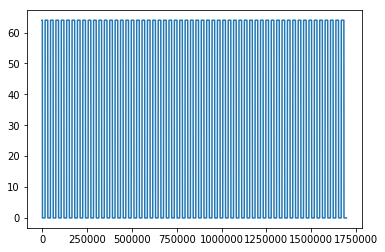

In [7]:
plt.plot(imec0['syn'])

In [8]:
sglu.get_imec_meta(meta_file_path)

{'nsavedchans': 385, 's_f': 30000.533148}

In [9]:
#### The last channel in both the ap and the lf binaries 

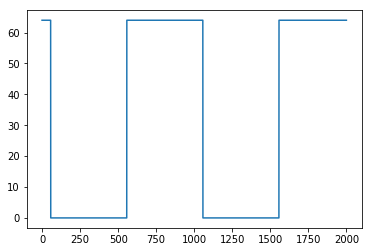

In [10]:
plot_ms = 2000

plt.plot(imec0['t_ms'][imec0['t_ms']<plot_ms], imec0['neural'][-1, imec0['t_ms']<plot_ms])

#### same for the nidq file
More detailed meta here https://github.com/billkarsh/SpikeGLX/blob/master/Markdown/Metadata.md.
- 

In [11]:
meta_file_path = os.path.join('/Users/zeke/experiment/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0/', '2019-05-27_stimsim_0000_00_g0_t0.nidq.meta')

# read all the ni_data and some of the metadata
nidq = sglu.get_ni_data(meta_file_path)

In [12]:
## look at that data a bit
nidq.keys()

dict_keys(['meta', 't_ms', 'adc', 'din'])

##### Plot the digital channels

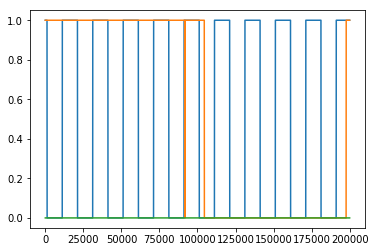

In [13]:
all_dig_stream = nidq['din']
plt.plot(all_dig_stream[0, :20000*10])
plt.plot(all_dig_stream[1, :20000*10])
plt.plot(all_dig_stream[2, :20000*10])

##### Plot the microphone channels

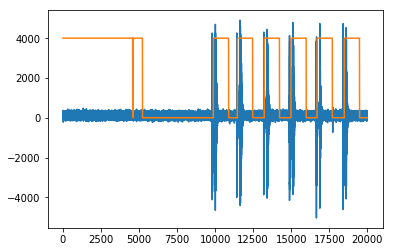

In [14]:
# plot mic chan together with the dig_in trigger channel
mic_chan = 0
plot_ms = 20000

# the trigger channel
trig_chan = 1

t_ms_nidq = nidq['t_ms']
data_nidq = nidq['adc']
plt.plot(t_ms_nidq[t_ms_nidq<plot_ms], data_nidq[mic_chan, t_ms_nidq<plot_ms])
plt.plot(t_ms_nidq[t_ms_nidq<plot_ms], nidq['din'][trig_chan, t_ms_nidq<plot_ms]*4000)

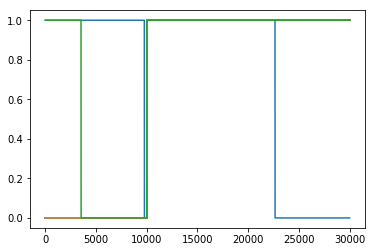

In [15]:
## get all the wavs aligned with the digital triggers
trig_chan = 1
trig_samples = np.where(np.diff(nidq['din'][trig_chan])==1)[0]

samp_pre = -10000
samp_post = 20000

d_frames_3d = sglu.quick_frames(nidq['din'], trig_samples, samp_pre, samp_post)
plt.plot(d_frames_3d[1, :, :].T);

##### now go for the analogs

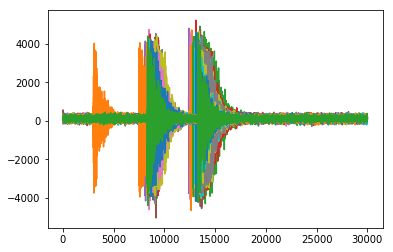

In [16]:
adc_frames_3d = sglu.quick_frames(nidq['adc'], trig_samples, samp_pre, samp_post)
plt.plot(adc_frames_3d[0, :, :].T);

## to do: same for imecs
 - do the align
 - compute the CAR, rms, threshold for all.
 - get channel maps and select the ones who are responsive

### Imec and nidq data sync check
Check that the sync channels are aligned (meaning the timestamps in both files make sense)

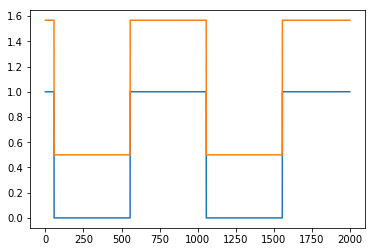

In [17]:
# plot the syn channels syde by side
plot_ms = 2000
syn_dig_in = 0 #digital channel in the nidaq used for syn

plt.plot(nidq['t_ms'][nidq['t_ms']<plot_ms], nidq['din'][syn_dig_in, nidq['t_ms']<plot_ms])
plt.plot(imec0['t_ms'][imec0['t_ms']<plot_ms], imec0['syn'][imec0['t_ms']<plot_ms]/60+0.5)

### convert timestamps from one to the other
- The trigger timestamps are in nidq sampling rate. These need to be rescaled to imec sampling rate. 
So do the windows.


In [18]:
trigger_stamps_ni = trig_samples
trigger_stamps_im = (trigger_stamps_ni / nidq['meta']['s_f'] * imec0['meta']['s_f']).astype(np.int)

samp_pre_im = int(samp_pre / nidq['meta']['s_f'] * imec0['meta']['s_f'])
samp_post_im = int(samp_post / nidq['meta']['s_f'] * imec0['meta']['s_f'])

neural_frames_3d = sglu.quick_frames(imec0['neural'], trigger_stamps_im, samp_pre_im, samp_post_im)
syn_frames_3d = sglu.quick_frames(np.expand_dims(imec0['syn'], axis=0), trigger_stamps_im, samp_pre_im, samp_post_im)

### plot the first trigger and the syn signal of both nidq and imec datam

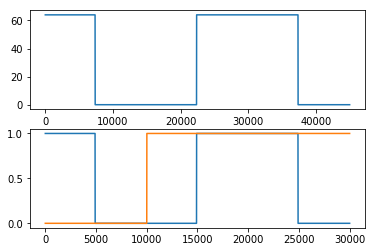

In [19]:
i_trig = 10

plt.subplot(211)
plt.plot(syn_frames_3d[0, i_trig,:])
plt.subplot(212)
plt.plot(d_frames_3d[0, i_trig,:])
plt.plot(d_frames_3d[1, i_trig,:])

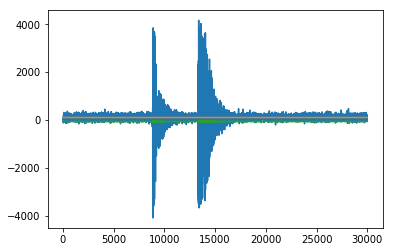

In [20]:
plt.plot(adc_frames_3d[:3, i_trig, :].T);

In [21]:
### do the car
### get peaks
#get peaks histo
#decide criterion for activity
#select ative chanes

In [22]:
z = adc_frames_3d[:3, i_trig, :] + 500
z.shape

(3, 30000)

In [23]:
np.mean(z, axis=1)

array([607.47513333, 601.97056667, 433.8627    ])

In [ ]:
from numba import jit
from pipefinch.util import jitarray as jita
reload(jita)

@jit(parallel=True)
def slow_car(x: np.array, ch_axis: int=0) -> np.ndarray:
    # remove offset
    sample_axis = (ch_axis + 1)%2
    y = x - np.expand_dims(np.median(x, axis=sample_axis), axis=1)
    return y

@jit(nopython=True, parallel=True)
def fast_offset(x: np.array) -> np.ndarray:
    # remove offset
    n_chan, n_sample = x.shape
    y = np.empty(x.shape)
    for i in np.arange(n_chan):
        y[i, :] = x[i, :] - np.mean(x[i, :])
    return y

@jit(nopython=True, parallel=True)
def fast_median_substract(x: np.array) -> np.ndarray:
    # remove common average (median) across col
    n_chan, n_sample = x.shape
    y = np.empty(x.shape)
    for i in np.arange(n_chan):
        y[i, :] = x[i, :] - np.median(x[i, :])
    return y


@jit(nopython=True, parallel=True)
def chunked_postprocess(raw_arr: np.array, post_arr:np.array, chunk_size=80000) -> np.ndarray:
    #postprocess:
    # pre and post are ready to be memmaped, for super large files
    # per chunk: 
    #  - remove offset
    #  - do CAR
    #  - filter?
    assert(raw_arr.shape == post_arr.shape), 'data array and post_array holder must be same shape'
    n_chan, n_sample = raw_arr.shape
    n_chunk = n_sample//chunk_size + 1
    print('Postprocessing file length ', n_sample)
    print('Total chunks: ', n_chunk)
    for i in np.arange(n_chunk):
        if not i%10:
            print('chunk', i, '/', n_chunk)
        chunk_start = i * chunk_size
        chunk_end = (i + 1) * chunk_size
        if chunk_end > n_sample:
            chunk_end = n_sample
        # fist do offset remove
        chunk_arr = jita.substract_mean_col(raw_arr[:, chunk_start:chunk_end])
        # now do CAR (mean substract along channels axis)
        post_arr[:, chunk_start:chunk_end] = jita.substract_mean_col(chunk_arr.T).T
    print('Done postprocessing')
    return post_arr
    
def postprocess_neural(meta_file_path: str):
    imec = sglu.get_imec_data(meta_file_path)
    bin_file_path = sglu.get_data_meta_path(meta_file_path)[0]
    logger.info('preprocessing file '.format({meta_file_path}))
    post_file_path = bin_file_path + '.car'
    
    data = imec['neural'] # this is a memmaped file
    logger.info('raw bin file has {} samples'.format(data.shape[1]))
    logger.info('Creating pre-processed file {}'.format(post_file_path))
    post_data = np.memmap(post_file_path, dtype=data.dtype, mode='w+', shape=data.shape)
    post_data = chunked_postprocess(data, post_data)
    logger.info('done')
    return(post_data)
    
#y = chunked_postprocess(z, np.empty(z.shape))
data_post = postprocess_neural(imec_meta_file_path)

2019-06-05 20:47:26,167 - root - INFO - preprocessing file 
2019-06-05 20:47:26,168 - root - INFO - raw bin file has 1695813 samples
2019-06-05 20:47:26,169 - root - INFO - Creating pre-processed file /Users/zeke/experiment/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0/2019-05-27_stimsim_0000_00_g0_imec0/2019-05-27_stimsim_0000_00_g0_t0.imec0.ap.bin.car


Postprocessing file length  1695813
Total chunks:  21
chunk 0 / 22


In [78]:
print('chunk', i, '/' , 10)

chunk 10 / 10


In [69]:
imec0['car'] = data_post

In [75]:
i=10
'chunk %i'%i

'chunk 10'

In [62]:
data_post.shape

(385, 1695813)

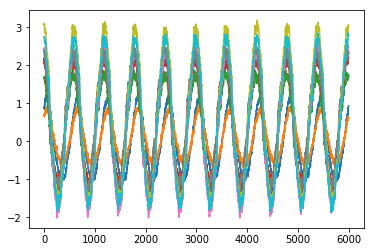

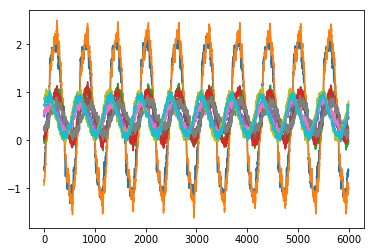

In [72]:
plot_ms=200
plt.plot(imec0['neural'][0:10, imec0['t_ms']<plot_ms].T/60+0.5)
plt.figure()
plt.plot(imec0['car'][0:10, imec0['t_ms']<plot_ms].T/60+0.5)

In [ ]:
print('tu vieja )

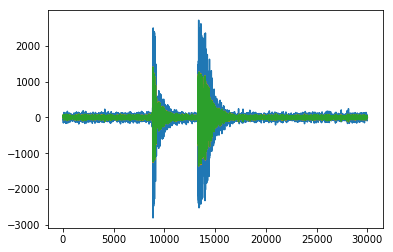

In [52]:
plt.plot(y.T)

In [51]:
z[:30000]

array([[596, 588, 576, ..., 614, 595, 595],
       [603, 602, 602, ..., 602, 602, 602],
       [440, 440, 440, ..., 440, 440, 441]], dtype=int16)

In [38]:
z.shape

(3, 30000)

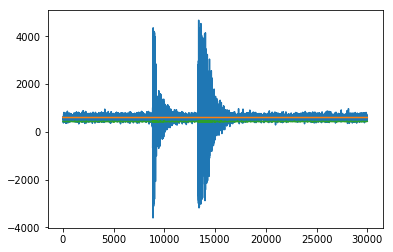

In [31]:
plt.plot(z.T);

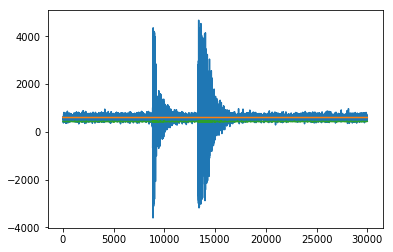

In [25]:
plt.plot(z.T)

In [28]:
np.mean(z, axis=1)

array([607.47513333, 601.97056667, 433.8627    ])

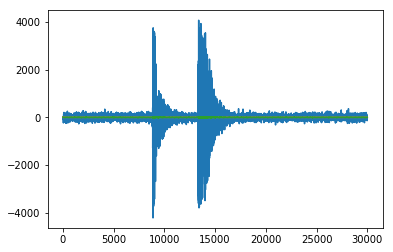

In [52]:
plt.plot(y.T)

In [53]:
import timeit
%timeit slow_car(z)

721 µs ± 23.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
